In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, mpld3
import pandas as pd, imp, glob, os, numpy as np
from sqlalchemy import create_engine
sn.set_context('notebook')

# TOC trends October 2016

Heleen would like updated results for the ICPW trends analysis at the beginning of October. Today is the last day of September and I'm committed to other projects for the next few weeks, so time is getting tight! The aim of this notebook is to get some more-or-less complete results that Heleen can work with while I'm away next week.

**Note:** There are still a number of significant issues with the database that I am unlikely to have time to fix in the near future. Although the ICPW dataset itself is pretty simple, cleaning up the existing system is not a small job, due to a long history of database structural development and, in particular, the way that RESA2 is coupled to various other systems. I'm not going to attempt to deal with these issues here, but I'll try to describe them below so I can come back in the future. The aim here is to try to produce something useful *despite* the outstanding known (and unknown?) issues.

## 1. ICPW database summary

Most of the tasks disucssed with John, Don and Heleen back in May have been completed, as described [here](http://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_trends_2015_data_cleaning.ipynb), [here](http://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_trends_2015_data_cleaning2.ipynb) and [here](http://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/updated_toc_trends_analysis2.ipynb). Section 5 of the latter notebook provides a more detailed summary.

On 25/08/2016, John sent a couple of very helpful e-mails in response to my earlier questions regarding the US sites. Unfortunately, comparing John's spreadsheets to the information in RESA2 highlighted a number of further database-wide errors (not specific to the US sites), which are going to be tricky to fix. A notebook describing this work in detail is [here](http://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_trends_2015_data_cleaning3.ipynb), but the main implications are summarised in an e-mail to Heleen (sent 02/09/2016 at 11:42), which is reproduced in part below.

> *"...it is not possible to reliably extract complete water chemistry time series from RESA2, even for just a single chemical parameter at a single site. This is because, if you choose a site that appears in both the core ICPW programme and in the wider trends analysis (which is most of them), you will find two time series in the database: one associated with 'ICPWaters' and another linked to 'TOC_TRENDS'. These two series will likely have different start and end points and different periods of missing data. There will also be a lot of overlap, and most of the overlapping values will agree, but in a few places they will be substantially different. What's more, at present the database will often report significantly different site properties for the two time series (i.e. different station names, geographic co-ordinates and catchment properties), despite the fact that the samples actually all come from a single location. All this means that if you want to look at a complete water chemistry time series for any site in ICP Waters, the only way to do it at the moment is to extract both series, manually merge them (e.g. in Excel) and then try to figure out which set of site properties is correct.* 

> *[...]*

> *At present it is possible for someone using RESA2 to extract two different time series and two sets of site properties for a single location. This is pretty confusing (as we found out back in May), and it also somewhat defeats the point of having a database."*

Other outstanding issues include the large number of Swedish sites with no data, problems with the Czech data (in an e-mail received 08/09/2016, Vladimir suggested just deleting and reloading everything) and the poor availability of site metadata for many locations. 

Having discussed these issues with Heleen, I've decided to try the following:

 * Tidy up the US sites based on information provided by John. I'm not going to attempt to merge any datasets at this stage, but I can clean up the site names and add the original USEPA site codes to reduce confusion. <br><br>
 
 * Look at the Czech data sent by Vladimir and decide whether it can and should replace the values currently in the database. <br><br>
 
 * Run the trends analysis using whatever data is currently associated with the `TOC_TRENDS` projects. In principle, these datasets were gathered together separately from ICPW for the 2015 reanalysis, which is why they're associated with separate projects in the database. As described in the notebook linked above, the values in these series sometimes do not agree with those reported for the core ICPW projects, but I'm going to ignore this for now as reconciling the differences will take a long time.

In [2]:
# Import custom functions and connect to db
resa2_basic_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Upload_Template'
                    r'\useful_resa2_code.py')

resa2_basic = imp.load_source('useful_resa2_code', resa2_basic_path)

engine, conn = resa2_basic.connect_to_resa2()

## 2. Tidy up US sites

Based on the results in the [previous notebook](http://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_trends_2015_data_cleaning3.ipynb), I'd like to go through all the US sites in RESA2 and modify the site properties to match the values in John's spreadsheet (which I'm taking to be definitive). In particular, I want to correct the station names and geographic co-ordinates, as well as appending the original USEPA site codes to the station metadata.

### 2.1. Core ICPW sites

We'll start by correcting the core ICPW sites. John's spreadsheet identified 95 sites that should be associated with this project and, following the work in the [previous notebook](http://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_trends_2015_data_cleaning3.ipynb), this now agrees with what's in RESA2. Four of the core ICPW sites in John's spreadsheet are marked `NA` in the `station_code` column. These sites do now have codes in RESA2, so I've created a new version of John's spreadsheet (*U.S.Site.Reconciliation.August.2016_jes.xlsx*) with these codes added. The first step is therefore to check that there is a direct match between codes for the 95 core sites in RESA2 and the the 95 sites listed in John's spreadsheet.

In [3]:
# Read John's spreadsheet
in_xls = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Call_for_Data_2016'
           '\Replies\usa\U.S.Site.Reconciliation.August.2016_jes.xlsx')
j_df = pd.read_excel(in_xls, sheetname='Sheet1')

# Get a subset of columns from John's spreadsheet
us_df = j_df[['Station Code', 'Station name', 'Suggested Name',
              'Active', 'INCLUDE IN ICP WATERS DATABASE', 
              'INCLUDE IN ICP DOC ANALYSIS', 'NFC_SITEID',
              'NFC_SITENAME', 'Latitude', 'Longitude', 'Altitude (m)']]

# Rename columns
us_df.columns = ['station_code', 'station_name', 'suggested_name',
                 'active', 'core', 'trend', 'nfc_code', 'nfc_name', 
                 'latitude', 'longitude', 'elevation']

# Just the core sites
core_df = us_df.query('core == "YES"')
core_df.head()

,station_code,station_name,suggested_name,active,core,trend,nfc_code,nfc_name,latitude,longitude,elevation
0,US24,"New York, Catskill Mnt., Rondout Creek","Rondout Creek, Catskills",YES,YES,YES,01364959,RONDOUT CREEK,41.9367,-74.3764,503.0
1,US25,"W Br Neversink R At Winnisook, Catskills","West Branch Neversink River at Winnisook, Cats...",YES,YES,YES,01434021,W BR NEVERSINK R AT WINNISOOK,41.9725,-74.4483,816.0
2,US26,"Biscuit Brook, Catskills","Biscuit Brook, Catskills",YES,YES,YES,01434025,BISCUIT BROOK,42.0111,-74.4147,634.0
3,US23,"New York, Catskill Mnt., E. Branch Neversink, ...","East Branch Neversink River, Catskills",YES,YES,YES,0143400680,"EAST BRANCH NEVERSINK, HEADWAT",41.9869,-74.5031,652.0
4,US27,"Little Hope Pond, Adirondacks","Little Hope Pond, Adirondacks",YES,YES,"NO, road salt contamination",020058O,LITTLE HOPE POND,44.5158,-74.1252,521.0


In [37]:
# Get station codes associated with 'ICP Waters US' project
sql = ('SELECT station_id, station_code, station_name, latitude, longitude '
       'FROM resa2.stations '
       'WHERE station_id in (SELECT station_id '
                             'FROM resa2.projects_stations '
                             'WHERE project_id = 1679)')
r2_df = pd.read_sql_query(sql, engine)
r2_df.head()

,station_id,station_code,station_name,latitude,longitude
0,23659,US24,"New York, Catskill Mnt., Rondout Creek",41.9600,-74.4500
1,23658,US23,"New York, Catskill Mnt., E. Branch Neversink, ...",43.1800,-74.5000
2,23660,US25,"W Br Neversink R At Winnisook, Catskills",42.0111,-74.4147
3,23661,US26,"Biscuit Brook, Catskills",41.9869,-74.5031
4,23662,US27,"Little Hope Pond, Adirondacks",44.5158,-74.1252


In [30]:
# Join
df = r2_df.merge(core_df, on='station_code', how='outer',
                 suffixes=('_r', '_j'))

if len(df) == 95:
    print 'All rows match.'
    
df.head()

All rows match.


,station_id,station_code,station_name_r,latitude_r,longitude_r,station_name_j,suggested_name,active,core,trend,nfc_code,nfc_name,latitude_j,longitude_j,elevation
0,23659,US24,"New York, Catskill Mnt., Rondout Creek",41.9600,-74.4500,"New York, Catskill Mnt., Rondout Creek","Rondout Creek, Catskills",YES,YES,YES,01364959,RONDOUT CREEK,41.9367,-74.3764,503.0
1,23658,US23,"New York, Catskill Mnt., E. Branch Neversink, ...",43.1800,-74.5000,"New York, Catskill Mnt., E. Branch Neversink, ...","East Branch Neversink River, Catskills",YES,YES,YES,0143400680,"EAST BRANCH NEVERSINK, HEADWAT",41.9869,-74.5031,652.0
2,23660,US25,"W Br Neversink R At Winnisook, Catskills",42.0111,-74.4147,"W Br Neversink R At Winnisook, Catskills","West Branch Neversink River at Winnisook, Cats...",YES,YES,YES,01434021,W BR NEVERSINK R AT WINNISOOK,41.9725,-74.4483,816.0
3,23661,US26,"Biscuit Brook, Catskills",41.9869,-74.5031,"Biscuit Brook, Catskills","Biscuit Brook, Catskills",YES,YES,YES,01434025,BISCUIT BROOK,42.0111,-74.4147,634.0
4,23662,US27,"Little Hope Pond, Adirondacks",44.5158,-74.1252,"Little Hope Pond, Adirondacks","Little Hope Pond, Adirondacks",YES,YES,"NO, road salt contamination",020058O,LITTLE HOPE POND,44.5158,-74.1252,521.0


The code above shows that all the sites have been matched correctly, so I can now loop over each site in the `ICP Waters US` project, updating the details in the stations table using the information in John's spreadsheet.

I also want to add the original National Focal Centre site code as an additional attribute (as John suggested in his e-mails). The easiest way to do this is to create a new entry (`NFC_Code`) in the `STATION_PARAMETER_DEFINITIONS` table.

In [48]:
# Loop over sites
for row in df.iterrows():
    # Get site properties
    stn_id = row[1]['station_id']
    name = row[1]['suggested_name']
    lat = row[1]['latitude_j']
    lon = row[1]['longitude_j']
    elev = row[1]['elevation']
    nfc = row[1]['nfc_code']

    # Update stations table
    sql = ("UPDATE resa2.stations "
           "SET station_name = '%s', "
               "latitude = %s, "
               "longitude = %s, "
               "altitude = %s "
           "WHERE station_id = %s" 
           % (name, lat, lon, elev, stn_id))

    result = conn.execute(sql)

    # Update stations_par_values table with NFC code
    sql = ("INSERT INTO resa2.stations_par_values "
           "(station_id, var_id, value, entered_by, entered_date) "
           "VALUES (%s, 321, '%s', 'JES', TO_DATE('2016-09-30', 'YYYY-MM-DD'))"
           % (stn_id, nfc))

    result = conn.execute(sql)

### 2.2. Trends sites

The next step is to correct the entries for the trends sites. Note that if the database was properly normalised this step wouldn't be necessary, as the 76 trends sites are a sub-set of the 95 core ICPW sites, so the steps described above should cover all relevant sites. However, due to the duplication of sites in the database, it is necessary to do this cleaning twice.

Matching the trends sites may turn out ot be a bit more difficult, because of inconsistencies in the `X15:` prefixes. The first step is to manually add `Newbert Pond, Maine` (`station_code = US82`) to the `ICPW_TOCTRENDS_2015_US_LTM` project, as mentioned at the end of the [previous notebook](http://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_trends_2015_data_cleaning3.ipynb). This should mean that we have 76 sites associated with the trends project, as specified in John's spreadsheet.

In [4]:
# Just the trend sites
trend_df = us_df.query('trend == "YES"')
trend_df.head()

,station_code,station_name,suggested_name,active,core,trend,nfc_code,nfc_name,latitude,longitude,elevation
0,US24,"New York, Catskill Mnt., Rondout Creek","Rondout Creek, Catskills",YES,YES,YES,01364959,RONDOUT CREEK,41.9367,-74.3764,503.0
1,US25,"W Br Neversink R At Winnisook, Catskills","West Branch Neversink River at Winnisook, Cats...",YES,YES,YES,01434021,W BR NEVERSINK R AT WINNISOOK,41.9725,-74.4483,816.0
2,US26,"Biscuit Brook, Catskills","Biscuit Brook, Catskills",YES,YES,YES,01434025,BISCUIT BROOK,42.0111,-74.4147,634.0
3,US23,"New York, Catskill Mnt., E. Branch Neversink, ...","East Branch Neversink River, Catskills",YES,YES,YES,0143400680,"EAST BRANCH NEVERSINK, HEADWAT",41.9869,-74.5031,652.0
5,US28,"Big Hope Pond, Adirondacks","Big Hope Pond, Adirondacks",YES,YES,YES,020059O,BIG HOPE POND,44.5119,-74.1250,522.0


In [118]:
# Get station codes associated with 'ICPW_TOCTRENDS_2015_US_LTM' project
sql = ('SELECT station_id, station_code, station_name, latitude, longitude '
       'FROM resa2.stations '
       'WHERE station_id in (SELECT station_id '
                             'FROM resa2.projects_stations '
                             'WHERE project_id = 3870)')

r2_df = pd.read_sql_query(sql, engine)

print 'Number of sites:', len(r2_df)

r2_df.head()

Number of sites: 76


,station_id,station_code,station_name,latitude,longitude
0,36983,X15:020059O,BIG HOPE POND,NaN,NaN
1,36984,X15:020138O,"East Copperas Pond, Adirondacks",44.3119,-74.3722
2,36985,X15:020188E,"Sunday Pond, Adirondacks",44.3447,-74.3005
3,36986,X15:020197E,"Sochia Pond, Adirondacks",44.3522,-74.2947
4,36987,X15:020265O,"Marcy Dam Pond, Adirondacks",44.1589,-73.9530


The next question is how well we can match these sites to John's spreadsheet. Based on the analysis in the previous notebook, the answer is, "*not very well*", because leading and trailing zeros in the original site codes have been truncated (presumably accidently, e.g. in Excel) prior to the `X15:` prefix being added. This isn't necessarily a major problem - the station codes used in RESA2 are mostly irrelevant - but I do need to somehow match them to John's spreadsheet and then update the station properties (preferably also adding the original site codes supplied by John, so we don't have to go through all this again later). The code below takes a slightly "heuristic" approach to finding matches.

In [121]:
# Loop over rows from John
for row in trend_df.iterrows():
    # Get site properties
    nfc_cd = row[1]['nfc_code']
    name = row[1]['suggested_name']
    lat = row[1]['latitude']
    lon = row[1]['longitude']
    elev = row[1]['elevation']  
        
    # Attempt to find match. Need to add 'X15:' and allow for variants
    q_res = r2_df[(r2_df['station_code']=='X15:%s' % nfc_cd) |
                  (r2_df['station_code']=='X15:%s' % nfc_cd[1:]) |
                  (r2_df['station_code']=='X15:%s' % nfc_cd[:-1])]
       
    if len(q_res) == 1:
        # Single match found. Get stn_id
        stn_id = q_res.iloc[0]['station_id']

        # Update stations table
        sql = ("UPDATE resa2.stations "
               "SET station_name = '%s', "
                   "latitude = %s, "
                   "longitude = %s, "
                   "altitude = %s "
               "WHERE station_id = %s" 
               % (name, lat, lon, elev, stn_id))

        result = conn.execute(sql)


        # Check whether there's already an entry for this site
        # in stations_par_values table
        sql = ('SELECT * FROM resa2.stations_par_values '
               'WHERE station_id = %s '
               'AND var_id = 321'
               % stn_id)
        
        df = pd.read_sql_query(sql, engine)
        
        if len(df) < 1:
            # Update stations_par_values table with NFC code        
            sql = ("INSERT INTO resa2.stations_par_values "
                   "(station_id, var_id, value, entered_by, entered_date) "
                   "VALUES (%s, 321, '%s', 'JES', TO_DATE('2016-09-30', 'YYYY-MM-DD'))"
                   % (stn_id, nfc_cd))

            result = conn.execute(sql)
       
    else:
        # Can't get good match
        print "Can't match %s." % nfc_cd

Can't match 1E1-134E.
Can't match ME-9998E.


This code manages to find unique matches for all but two of the sites, which is a good start. Looking at the site codes for the two exceptions in John's spreadsheet, it seems as though they were previously only associated with core ICPW project and not the broader trends analysis. They were therefore not duplicated when the `TOC Trends` projects were created and instead only appear in the database once, using station codes `US74` and `US82`, respectively (rather than any of the `X15:` stuff.

### 2.3. Testing

With a bit of luck, I've finally managed to sort out the basic details for the US sites. Let's check.

In [5]:
# Get the NFC site codes
sql = ('SELECT station_id, value AS nfc_code '
       'FROM resa2.stations_par_values '
       'WHERE var_id =321')
nfc_df = pd.read_sql_query(sql, engine)

# Get station codes associated with 'ICP Waters US' project
sql = ('SELECT station_id, station_code, station_name, latitude, longitude, altitude '
       'FROM resa2.stations '
       'WHERE station_id in (SELECT station_id '
                             'FROM resa2.projects_stations '
                             'WHERE project_id = 1679)')
core_df = pd.read_sql_query(sql, engine)

# Get station codes associated with 'ICPW_TOCTRENDS_2015_US_LTM' project
sql = ('SELECT station_id, station_code, station_name, latitude, longitude, altitude '
       'FROM resa2.stations '
       'WHERE station_id in (SELECT station_id '
                             'FROM resa2.projects_stations '
                             'WHERE project_id = 3870)')
trend_df = pd.read_sql_query(sql, engine)

# Join in original site codes
core_df = core_df.merge(nfc_df, on='station_id', how='left')
trend_df = trend_df.merge(nfc_df, on='station_id', how='left')

print 'Sites in core ICPW project:', len(core_df)
print 'Sites in trends project:   ', len(trend_df)

Sites in core ICPW project: 95
Sites in trends project:    76


Regardless of the station codes and IDs in RESA2, I should now be able to make sense of the US data using the actual USEPA codes. For example, the sites in `trend_df` should be a well defined sub-set of those in `core_df`, and all the site properties should agree.

In [9]:
# Inner join dfs
df = trend_df.merge(core_df, on='nfc_code', how='inner', 
                    suffixes=('_t', '_c'))

# Testing
assert len(df) == 76, 'Incorrect number of sites.'

for item in ['station_name', 'latitude', 'longitude', 'altitude']:
    assert (df[item + '_t'] == df[item + '_c']).all(), 'Mismatch in %ss.'

print 'Check complete. All properties match.'

Check complete. All properties match.


Great - I think the US LTM sites are now more-or-less sorted. Only another 20 countires to go! Note that, with the changes made above, it is now possible to extract the NFC station codes from RESA2 in the same way as for the other station properties (i.e. using the `Additional station data` tab). There are still some issues to be aware of though. In particular, if you choose to export station properties from RESA2 to Excel, the RESA2 code will convert any all-numeric NFC codes to numbers. The result is that NFC codes such as `013425` are truncated as `12345`. This is not a problem with the database (the values in Oracle are correct) - it is a problem with the RESA2 code that copies results from the database into Excel. I'm not going to delve into this at the moment as I'm keen to avoid becoming too involved in the RESA2 application itself. As a workaround, it is safer to export from RESA2 as CSV and then import the CSV into Excel, taking care to set the column type for the `nfc_code` field to `Text` during the impoort process.

## 3. Czech data

Vladimir has suggested deleting all the Czech data and then uploading it again from scratch. I'm reluctant to delete more than a decade's worth of data, but an alternative option more consistent with what's been done before would be to rename the existing Czech site codes and shift them into and `EXCLUDED` project. I can then upload the new Czech data using the same site codes as previously, which will hopefully avoid the issues created when the trend data was similarly uploaded, but using modified (i.e. `X15:`) prefixes.

Firstly, some points to note:

 * The "old" database has Czech data for 9 sites. Two of these, Lysina (`CZ07`) and Pluhuv Bor (`CZ09`) have higher resolution data than the rest. See Section 3 of [this notebook](http://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_trends_2015_data_cleaning2.ipynb) for full details. <br><br>
 
 * In his latest data submission, Vladimir has only supplied **monthly** resolution data for sites `CZ01` to `CZ08` inclusive (i.e. excluding Pluhuv Bor). This is exactly what's required for the core ICPW dataset, but we may wish to include some of old (weekly) data from Lysina and Pluhuv Bor in the trends analysis (assuming it's considered good enough to use).
 
For the moment, I propose **shifting all of the existing Czech data (sites `CZ01` to `CZ09`) into a new project called `ICPWaters CZ Excl`**. I will then upload the new data for sites `CZ01` to `CZ08` and associate these records with **both** the core ICPW project and the trend analysis work. Both projects will therefore access exactly the same (monthly resolution) data, which is more consistent than the data structure used at present. The downsides are that the trends project will then make use of lower resolution (monthly rather than weekly) data for Lysina (`CZ07`) and have no data at all for Pluhuv Bor (`CZ09`). Given that we are estimating trends from annual averages anyway, I don't think the differences in temporal resolution are a problem (in fact, using monthly data is arguably better as it's more consistent with our statistical analyses elsewhere). It is also possible to include Pluhuv Bor in the trends project if we want to, but Jakub has previously stated that it is a very well-buffered catchment that does not suffer from acidification (see e-mail received 29/06/2016 at 10:58), so I'm not sure it's appropriate anyway? **Check with Heleen**.

### 3.1. Restructure Czech projects

The first step is to create a new project called `ICPWaters CZ Excl`. I can then rename all the existing Czech site codes (`CZ01` etc.) by adding the suffix `_Old`, followed by shifting them over to the newly created project. The second step is to create 8 new sites (with identical properties to the old ones), assigning them the same site codes as used previously (`CZ01` etc.). These new sites have no data associated with them, so I should be able to upload the revised data from Vladimir without creating any conflicts (I hope). All of this is most easily done manually using Access.

**Note:** This process involves creating duplicate sites and is therefore superficially similar to the duplication described above, which has already caused lots of confusion. However, these problems have primarily been caused because we have two sets of sites (core and trends), which represent the same locations but which often have different site properties. More importantly, both of these projects are considered "active", and data is periodically appended to update them. This is what causes the problems: we have two supposedly identical datasets evolving in parallel, and over time differences emerge that are difficult to correct.

For the Czech sites, I'm moving all the old data into an `EXCLUDED` project, marking the site names as `OLD`, and also adding a description to the `STATIONS` saying they are `Associated with data supplied prior to August 2016`. In principle, I'd be happy to delete all of this data entirely (which would remove any concerns about duplication and database normalisation etc.), but I don't want to lose any information if I can avoid it. Besides, deleting records from RESA2 is rather fiddly due to all the other database interactions (a topic I'd like to avoid getting involved in for the moment). My hope is that the changes I'm making here will not cause further confusion, because the sites with the suffix `_Old` will be discontinued completely i.e. no new data will be associated with them and they won't be used in subsequent projects. This should avoid the messy situation that we're now in with sites from other countries.

### 3.2. Upload new data

With the new project structure in place, I can use *upload_icpw_template.ipynb* to load the latest data from Vladimir into the database. This seems to have worked successfully, but for some reason the available parameters for the new sites are not showing up properly in the RESA2 application. They are there, and the values appear to be correct, but the `Refresh parameter list` button is not working as it used to. However, if the `STANDARD` button is pressed to select the routine parameters of interest, everything works as expected and the data can be exported to Excel as usual. The bit that's missing is that the user no longer has the option of selecting custom parameters. I'm not sure what's happening here - another of the mysteries of RESA2! I'll have to **ask Tore where his code pulls this information from and modify the database accordingly**, but I'm not going to worry about this for now, as all my code will interact directly with the underlying Oracle database itself.

### 3.3. Data checking

To check that my changes have worked as expected I want to compare the data now in the database with what's in Vladimir's spreadsheet. To do this, I've manually extracted time series for the 8 Czech sites from RESA2 and saved them in *check_czech.xlsx*. The code below plots these values from RESA2 against the raw values in Valdimir's spreadsheet, which hopefully should not agree.

In [29]:
# Read data
in_xlsx = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Call_for_Data_2016'
            '\Replies\czech_republic\check_czech.xlsx')
r2_df = pd.read_excel(in_xlsx, sheetname='RESA')
vl_df = pd.read_excel(in_xlsx, sheetname='Orig')

C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


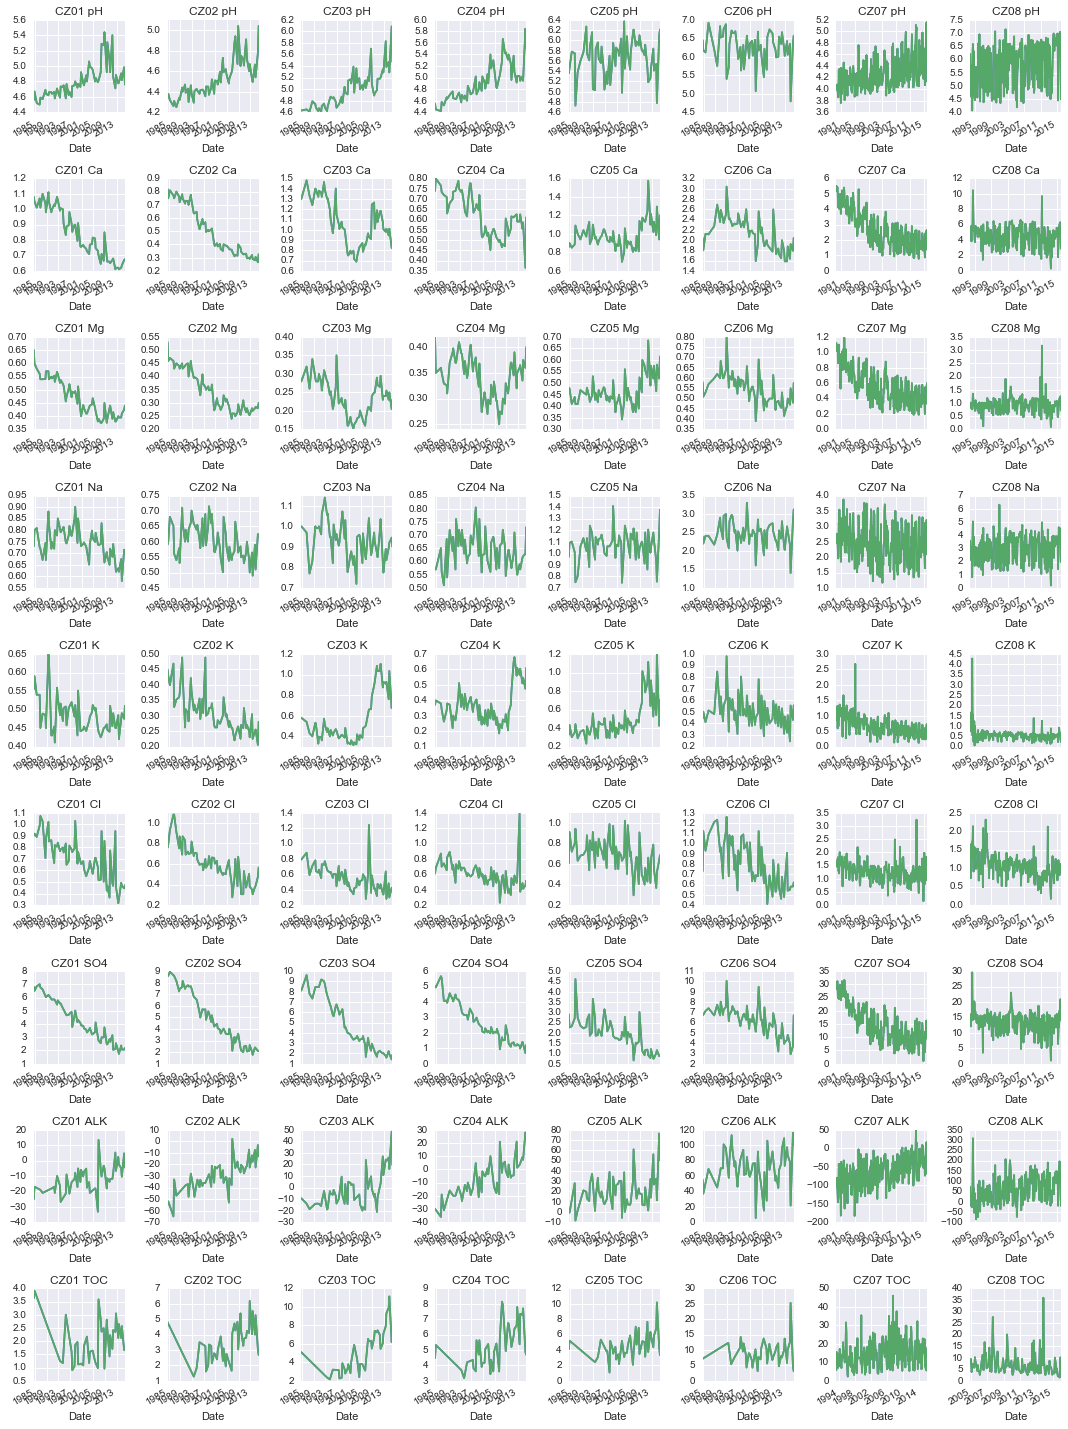

In [35]:
# Define params of interest
params = ['pH', 'Ca', 'Mg', 'Na', 'K', 'Cl', 'SO4', 'ALK', 'TOC']

fig, axes = plt.subplots(nrows=9, ncols=8, figsize=(15, 20))

# Loop over data
for row, param in enumerate(params):
    # Get data
    df1 = r2_df[['Code', 'Date', param]]
    df2 = vl_df[['Code', 'Date', param]]
    
    # Pivot
    df1 = df1.pivot(index='Date', columns='Code', values=param)
    df2 = df2.pivot(index='Date', columns='Code', values=param)
    
    # Join
    df = df1.merge(df2, how='outer', 
                   left_index=True, right_index=True)
    
    for site in range(1, 9):
        # Get data for this site
        s_df = df[['CZ%02d_RESA' % site, 'CZ%02d_Orig' % site]]
        s_df.dropna(how='any', inplace=True)
        
        # Plot
        s_df.plot(ax=axes[row, site-1], legend=False)
        axes[row, site-1].set_title('CZ%02d %s' % (site, param))

plt.tight_layout()        
plt.show()